# Project 2

Alice Ding, Shoshana Farber, Christian Uriostegui

The goal of this project is to:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

The dataset we are using is from the Bureau of Transporation Statistics, specifically from the Airline Origin and Destination (DB1B) [database](https://www.transtats.bts.gov/TableInfo.asp?gnoyr_VQ=FHK&QO_fu146_anzr=b4vtv0%20n0q%20Qr56v0n6v10%20f748rB&V0s1_b0yB=D). The dataset used can be found in the [GitHub folder Week 4 - Part 1](https://github.com/addsding/cuny-data620/tree/main/week4_part1) assignment.  Because the dataset exceeds a million rows, we will be looking a smaller subset of data for practical purposes. The full original dataset can be found [here](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FHK&QO_fu146_anzr=b4vtv0+n0q+Qr56v0n6v10+f748rB). 

The dataset contains information on the origin and destination markets provided in the Origin and Destination Survey (DB1B). This is a 10% sample of airline ticket purchases from carriers. In addition, you can find information on the number of passengers, as well as origin and destination airlines. This information is recorded each quarter and has been reported since 1993. 

For our analysis, we will be looking at data from 2022 in the first quarter. We are interested in examining popular destination places by airports in the United States.

***

### Loading the Data

In [1]:
import numpy as np
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

In [2]:
survey = pd.read_csv('https://raw.githubusercontent.com/addsding/cuny-data620/main/week4_part1/T_DB1B_MARKET_1.csv')

In [3]:
survey.head(15)

,ITIN_ID,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_STATE_ABR,DEST_STATE_NM,REPORTING_CARRIER,PASSENGERS
0,2022149,10868,1086803,30868,CAE,SC,South Carolina,13204,1320402,31454,MCO,FL,Florida,3M,1
1,2022150,10868,1086803,30868,CAE,SC,South Carolina,13204,1320402,31454,MCO,FL,Florida,3M,1
2,2022151,10868,1086803,30868,CAE,SC,South Carolina,13204,1320402,31454,MCO,FL,Florida,3M,1
3,2022151,13204,1320402,31454,MCO,FL,Florida,10868,1086803,30868,CAE,SC,South Carolina,3M,1
4,2022152,10868,1086803,30868,CAE,SC,South Carolina,13204,1320402,31454,MCO,FL,Florida,3M,1
5,2022152,13204,1320402,31454,MCO,FL,Florida,10868,1086803,30868,CAE,SC,South Carolina,3M,1
6,2022153,10868,1086803,30868,CAE,SC,South Carolina,11697,1169706,32467,FLL,FL,Florida,3M,1
7,2022154,10868,1086803,30868,CAE,SC,South Carolina,15304,1530402,33195,TPA,FL,Florida,3M,1
8,2022155,10868,1086803,30868,CAE,SC,South Carolina,15304,1530402,33195,TPA,FL,Florida,3M,1
9,2022156,10868,1086803,30868,CAE,SC,South Carolina,15304,1530402,33195,TPA,FL,Florida,3M,1


Our dataframe titled **survey** contains the following columns:
- `ITIN_ID`- This contains the unique itenary ID for each flight
- `ORIGIN_AIRPORT_ID` - Origin airport id
- `ORIGIN_AIRPORT_SEQ_ID` - Origin airport sequence id
- `ORIGIN_CITY_MARKET_ID` - Origin city market
- `ORIGIN` - Origin airport code
- `ORIGIN_STATE_ABR` - Origin state abbreviation
- `ORIGIN_STATE_NM`- Origin state full name
- `DEST_AIRPORT_ID` - Destination airport id
- `DEST_AIRPORT_SEQ_ID` - Destination airport sequence id
- `DEST_CITY_MARKET_ID` -Destination city market id
- `DEST` - Destination airport code
- `DEST_STATE_ABR` - Destination state abbreviation
- `DEST_STATE_NM` - Destination state name
- `REPORTING_CARRIER` - Reporting carrier code (3M = Silver Airways, 9E = Endeavor Air Inc., AA = American Airlines Inc.)
- `PASSENGERS` - Number of passengers traveling per itinerary

For our analysis, we will be examining the columns `ORIGIN` and `DEST_STATE_ABR`.
***

### Exploratory Analysis
**What are the airports and destination states in the dataset?**

In [4]:
print("There are",len(survey['ORIGIN'].unique()), "airports and they are", survey['ORIGIN'].unique(),"\n")
print("There are",len(survey['DEST_STATE_ABR'].unique()), "destination states and they are", survey['DEST_STATE_ABR'].unique())

There are 297 airports and they are ['CAE' 'MCO' 'CHS' 'FLL' 'TPA' 'EYW' 'PNS' 'HSV' 'JAX' 'SAV' 'TLH' 'GSP'
 'IAD' 'IAH' 'MSY' 'LAX' 'ATL' 'COS' 'ORD' 'SJU' 'STT' 'STX' 'EWR' 'ABE'
 'ABQ' 'AGS' 'ATW' 'AUS' 'AVL' 'BHM' 'BMI' 'BNA' 'BOI' 'BZN' 'CHA' 'CLE'
 'CMH' 'CRW' 'CSG' 'DAB' 'DAL' 'DEN' 'DFW' 'ELP' 'DHN' 'DSM' 'ECP' 'EVV'
 'GNV' 'GPT' 'GSO' 'DTW' 'HHH' 'HNL' 'HOU' 'ICT' 'JAN' 'PBI' 'LAS' 'LEX'
 'LFT' 'LIT' 'MCI' 'MDW' 'MEM' 'MGM' 'MIA' 'MKE' 'MLB' 'MLU' 'BTR' 'MOB'
 'MSP' 'MYR' 'OKC' 'OMA' 'ONT' 'PDX' 'PHX' 'PSP' 'RDU' 'RSW' 'SAN' 'SAT'
 'SDF' 'SEA' 'MFR' 'SFO' 'SGF' 'SHV' 'SLC' 'OAK' 'SMF' 'SNA' 'SRQ' 'STL'
 'TUL' 'TUS' 'TYS' 'VPS' 'CVG' 'GRB' 'GRR' 'IND' 'LAN' 'MBS' 'MSN' 'GEG'
 'PIT' 'ABY' 'ALB' 'BDL' 'BOS' 'LGA' 'BWI' 'CLT' 'DAY' 'DCA' 'JFK' 'HDN'
 'HPN' 'LBB' 'JAC' 'MDT' 'MTJ' 'OAJ' 'ORF' 'PHL' 'RIC' 'ROC' 'FAI' 'SYR'
 'AEX' 'BQK' 'ELM' 'FAY' 'FWA' 'ILM' 'PWM' 'ANC' 'PSC' 'PVD' 'TRI' 'VLD'
 'ASE' 'SLK' 'BTV' 'BUF' 'EGE' 'FSD' 'LIH' 'RNO' 'SJC' 'MLI' 'BIL' 'BJI'
 'CWA' 'DLH' 'F

Now that we know about the airports and destination places in the data, we can look at the frequency for each column.
***
**Which airports had the most trips?**

In [5]:
survey.groupby('ORIGIN').count().iloc[:, 0].sort_values(ascending=False).head(1)

ORIGIN
BOS    22031
Name: ITIN_ID, dtype: int64

Boston Logan International Airport (BOS) had the most trips, with **22,031** flights originating from there.

***

**What is the most frequently visited destination?**

In [6]:
survey.groupby('DEST_STATE_ABR').count().iloc[:,0].sort_values(ascending=False).head()

DEST_STATE_ABR
FL    31049
NY    26804
TX    22762
NC    18130
MA    16062
Name: ITIN_ID, dtype: int64

The most frequent destination is Florida with **31,049**, and next is New York with **26,804**.

***

**Top 10 and Bottom 10 Origin Airports**

In [7]:
survey.groupby('ORIGIN').count().iloc[:,0].sort_values(ascending=False).head(10)

ORIGIN
BOS    22031
AUS    14605
ATL    13838
CLT    13164
LGA    11916
BNA     9442
CLE     6132
JFK     5861
MIA     5231
BWI     4962
Name: ITIN_ID, dtype: int64

As mentioned above, Boston Logan International Airport (BOS) had the most trips, with **22,031** flights originating from there. Austin International Airport (AUS), Atlanta International Airport (ATL), Charlotte Douglas in North Carolina (CLT), and LaGuardia Airport in New York (LGA) also appear in the top five, with **over 10,000** flights originating from these airports. Nashville International Airport (BNA) has just under 10,000 flights. The last four airlines in the top ten are Cleveland Hopkins International Airport (CLE), John F. Kennedy Airport in New York (JFK), Miami International Airport (MIA), and Baltimore/Washington International Aiport (BWI). 

In [8]:
survey.groupby('ORIGIN').count().iloc[:,0].sort_values().head(10)

ORIGIN
IRK    1
RDD    1
PKB    1
PGA    1
MWA    1
MSS    1
MSL    1
CNM    1
MAZ    1
LNY    1
Name: ITIN_ID, dtype: int64

There are a number of airports with only one flight departing in the first quarter of 2022. 

**How many aiports had only one flight departing?**

In [34]:
single_flight = []

flight_counts = survey.groupby('ORIGIN').count().iloc[:,0].to_dict()

for key, val in flight_counts.items():
    if val == 1:
        single_flight.append(key)

print("There were", str(len(single_flight)), "airports with only one flight departing from it. These are", str(single_flight))

There were 23 airports with only one flight departing from it. These are ['BTM', 'CNM', 'EKO', 'GLH', 'HIB', 'HOM', 'HOT', 'IMT', 'IRK', 'JNU', 'KTN', 'LEB', 'LNK', 'LNY', 'MAZ', 'MSL', 'MSS', 'MWA', 'PGA', 'PKB', 'RDD', 'TUP', 'UIN']


- BTM: Bert Mooney Airport (Montana)
- CNM: Central New Mexico Airport
- EKO: Elko Regional Airport (Nevada)
- GLH: Tallahassee International Airport
- HIB: Range Regional Airport (Hibbing, Minnesota)
- HOM: Homer Airport (Alaska)
- HOT: Hot Springs Airport (Arkansas)
- IMT: Ford Airport (Michigan)
- IRK: Kirksville Regional Airport (Missouri)
- JNU: Juneau International Airport (Alaska)
- KTN: Ketchikan International Airport (Alaska)
- LEB: Lebanon Municipal Airport (New Hampshire)
- LNK: Lincoln Airport (Nebraska)
- LNY: Lanai Airport (Hawaii)
- MAZ: Aeropuerto Eugenio María de Hostos (Peurto Rico)
- MSL: Northwest Alabama Regional Airport 
- MSS: Massena International Airport (New York)
- MWA: Veterans Airport of Southern Illinois
- PGA: Page Municipal Airport (Arizona)
- PKB: Mid-Ohio Valley Regional Airport (West Virginia)
- RDD: Redding Regional Airport (California)
- TUP: Tupelo Regional Airport (Mississippi)
- UIN: Quincy Regional Airport (Illinois)

***

**Top 10 and Bottom 10 Destinations**

In [10]:
survey.groupby('DEST_STATE_ABR').count().iloc[:,0].sort_values(ascending=False).head(10)

DEST_STATE_ABR
FL    31049
NY    26804
TX    22762
NC    18130
MA    16062
GA    15384
CA    13648
TN    11436
VA     9482
MI     7853
Name: ITIN_ID, dtype: int64

Florida, New York, and Texas and the top 3 most traveled destinations, with more than 20,000 flights to them. Also in the top 10 are North Carolina, Massachusetts, Georgia, Califonia, Tennessee, Virginia, and Michigan. 

In [11]:
survey.groupby('DEST_STATE_ABR').count().iloc[:,0].sort_values().head(10)

DEST_STATE_ABR
TT      6
NH     74
AK    312
ID    322
WY    383
KS    447
NE    515
WV    538
ND    550
SD    578
Name: ITIN_ID, dtype: int64

The lowest traveled to destination is TT, which, according to Google, is the Trust Territory of the Pacific Islands. After that is New Hampshire, Alaska, Idaho, Wyoming, Kansas, Nebraska, West Virginia, North Dakota, and South Dakota. 

***

### Creating the Network

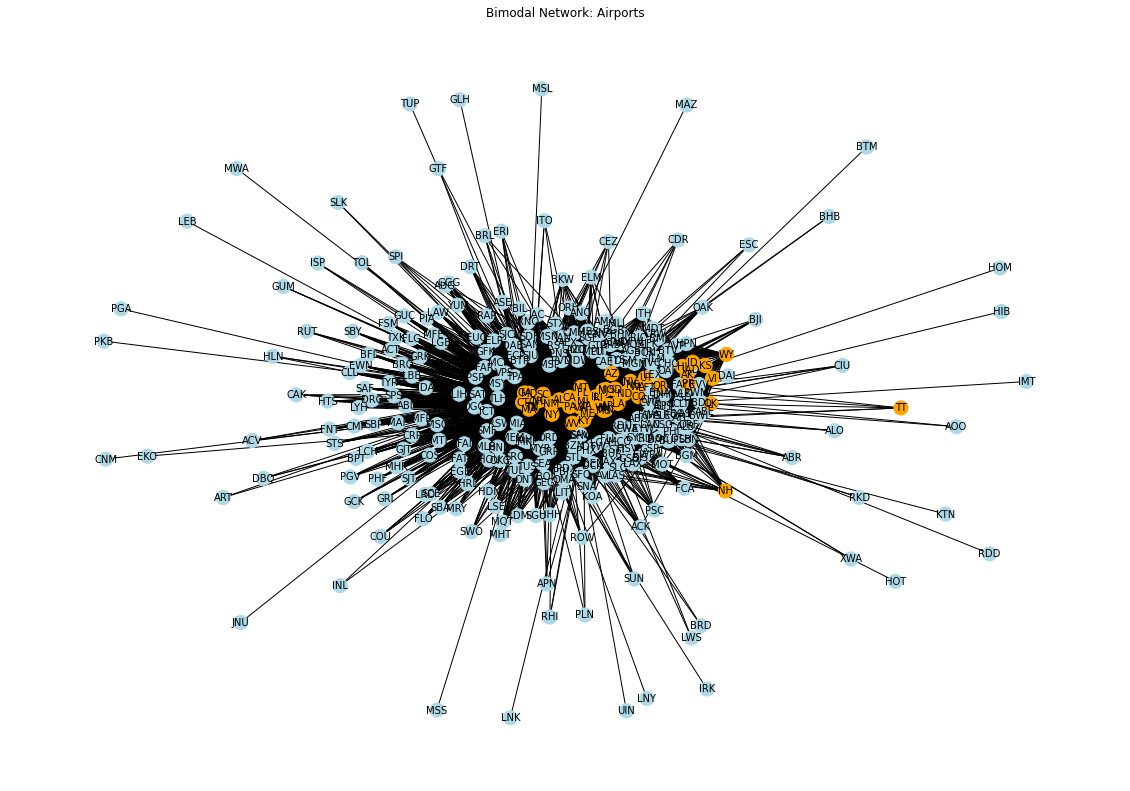

In [12]:
plt.figure(figsize=(20,14))

# Create an empty graph
G = nx.Graph()

# Add the nodes and edges to the graph
G.add_nodes_from(survey['ORIGIN'], bipartite=0)  # Airport nodes
G.add_nodes_from(survey['DEST_STATE_ABR'], bipartite=1)  # Destination state nodes
G.add_edges_from(list(zip(survey['ORIGIN'], survey['DEST_STATE_ABR'])))  # Edge between airport and destination

# Network visualization
pos = nx.spring_layout(G, seed = 2345)
node_color = ['lightblue' if d['bipartite'] == 0 else 'orange' for _, d in G.nodes(data=True)]  # use colors to differentiate airport (blue) from state (orange)
nx.draw_networkx(G, pos, node_size=200, font_size=10, node_color=node_color)


plt.title("Bimodal Network: Airports")
plt.axis("off")
plt.show()

Let's confirm that graph object G is in a bipartite format.

In [13]:
nx.is_bipartite(G)

True

In [14]:
print(G)

Graph with 349 nodes and 7133 edges


Now let's graph the projections for airport and destination. 

***

### Airports

In [35]:
# get the projection for airports
airports = bipartite.weighted_projected_graph(G, survey['ORIGIN'])

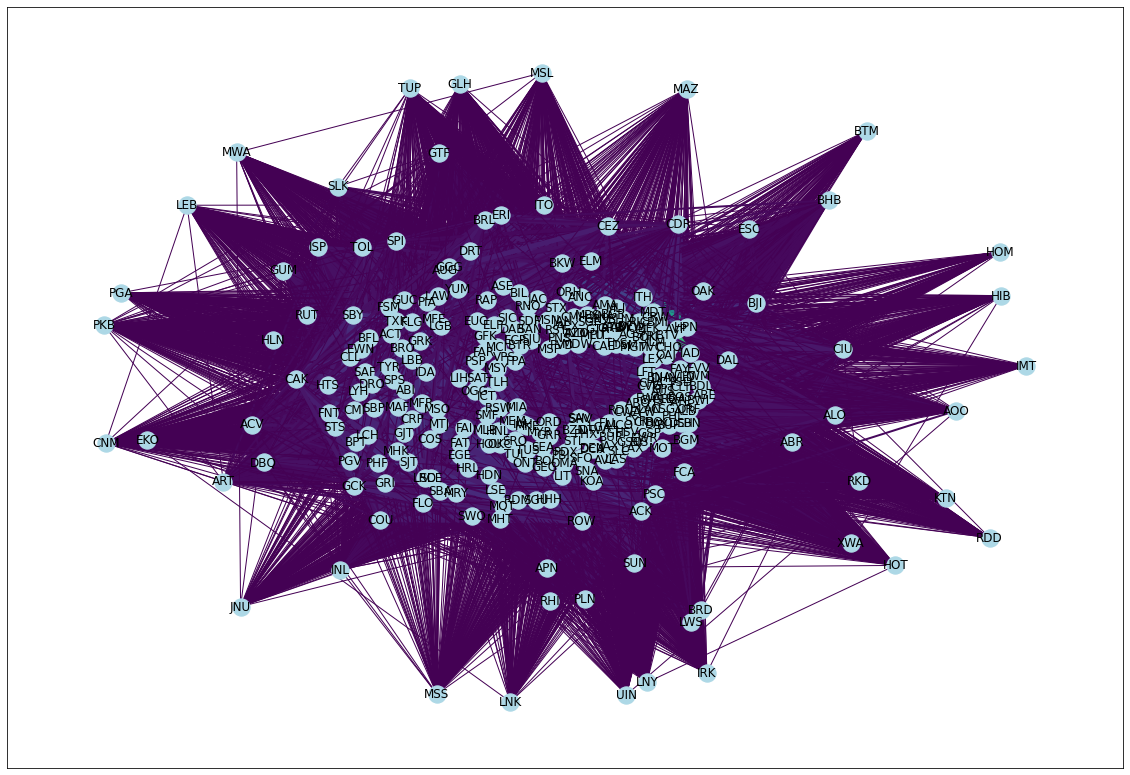

In [16]:
plt.figure(figsize=(20,14))

weights = [edata['weight'] for f, t, edata in airports.edges(data = True)]
nx.draw_networkx(airports, pos, width = weights, edge_color = weights, node_color = 'lightblue')    # include weights

plt.show()

In [17]:
print(airports)

Graph with 297 nodes and 41106 edges


This looks like one fully connected component. We can see the thicker purple lines connecting the airports in the middle.

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([296.5, 296.6, 296.7, 296.8, 296.9, 297. , 297.1, 297.2, 297.3,
        297.4, 297.5]),
 <BarContainer object of 10 artists>)

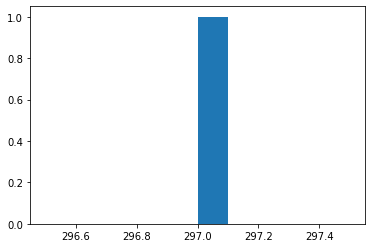

In [18]:
x=[len(c) for c in nx.connected_components(airports)]
plt.hist(x)

This shows that this is one fully connected component. 

***

Now let's implement the island method from the book to trim down the network.

In [19]:
# SNA function for trimming edges
def trim_edges(g, weight=1):
    g2 = nx.Graph()
    edges = []

    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            edges.append([f, to, edata['weight']])
        
    g2.add_weighted_edges_from(edges)
    return g2

# SNA function for island method
def island_method(g, iterations = 5):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]

    mn = int(min(weights))
    mx = int(max(weights))
    step = int((mx-mn)/iterations)

    return[[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

In [20]:
airport_islands = island_method(airports)

for i in airport_islands:
    print(i[0], nx.number_of_nodes(i[1]), nx.number_connected_components(i[1]))

1 274 1
11 201 1
21 162 1
31 127 1
41 58 1
51 2 1


Every iteration only includes one connected component. With a threshold of 41, there is one connected component of 58 nodes. With a threshold of 51, there is one connected component of 2 nodes.

Let's graph this island using different colors to differentiate between those airports which did and didn't make it in the top 10. For this we will create a color dictionary for the nodes in this island. If the airport appeared in the top 10, the color of the node will be pink. If not, the color will be blue.

In [21]:
# find the top 10
top_10_airport = survey.groupby('ORIGIN').count().iloc[:,0].sort_values(ascending=False).head(10).to_dict()

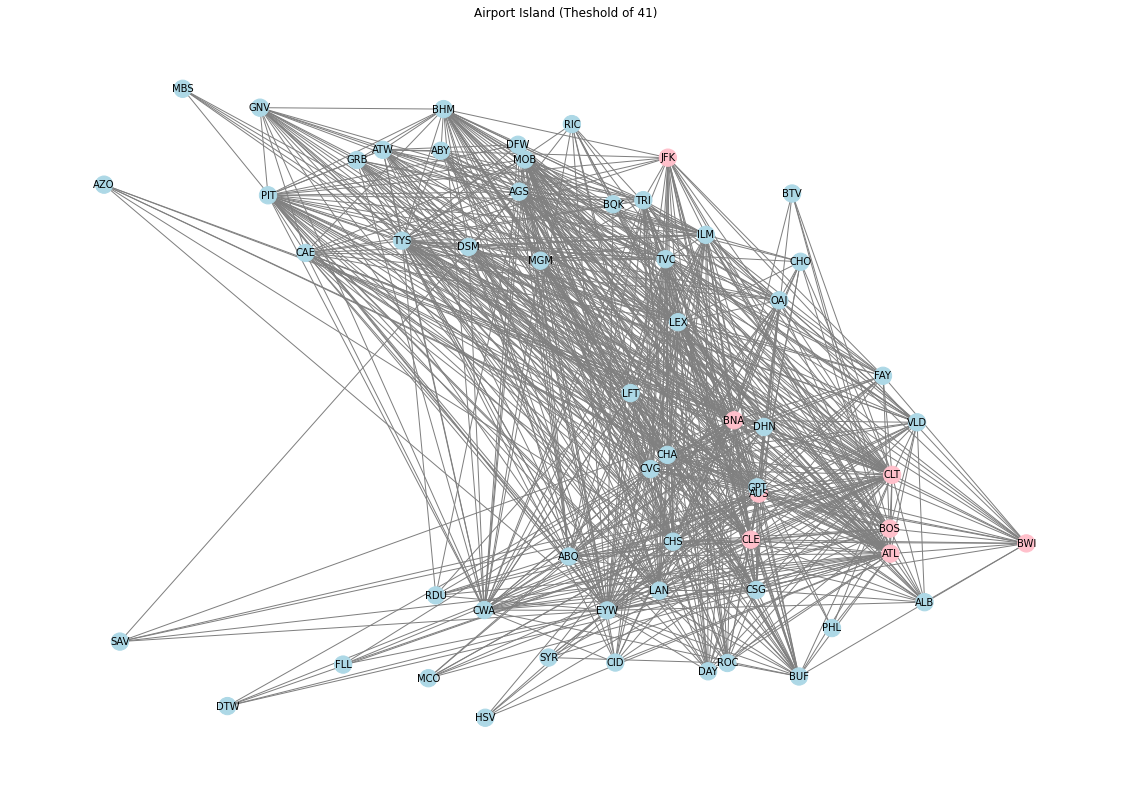

In [22]:
plt.figure(figsize=(20,14))

# create color dictionary
color_dict = {}

for node in airport_islands[4][1].nodes():
    if node in top_10_airport.keys():
        color_dict[node] = 'pink'   # pink for top 10
    else:
        color_dict[node] = 'lightblue'  # blue for others

nx.draw_networkx(airport_islands[4][1], pos, node_size=300, font_size=10, node_color=color_dict.values(), edge_color='grey')

plt.title("Airport Island (Theshold of 41)")
plt.axis("off")
plt.show()

We can see a few of the better connected airports in this graph. Included amongst them are BOS (Boston), ATL (Atlanta), AUS (Austin), JFK (New York), CLE (Cleveland), BWI (Baltimore/Washington), CLT (North Carolina), and BNA (Nashville). Interestingly, LaGuardia Airport in New York (LGA) and Miami International Airport in Florida (MIA) did not make the cut, even though they were included amongst the top 10 airports.  

Many of the airports included in this island, specifically those which are clustered in the dense middle, are likely to serve as hubs. 

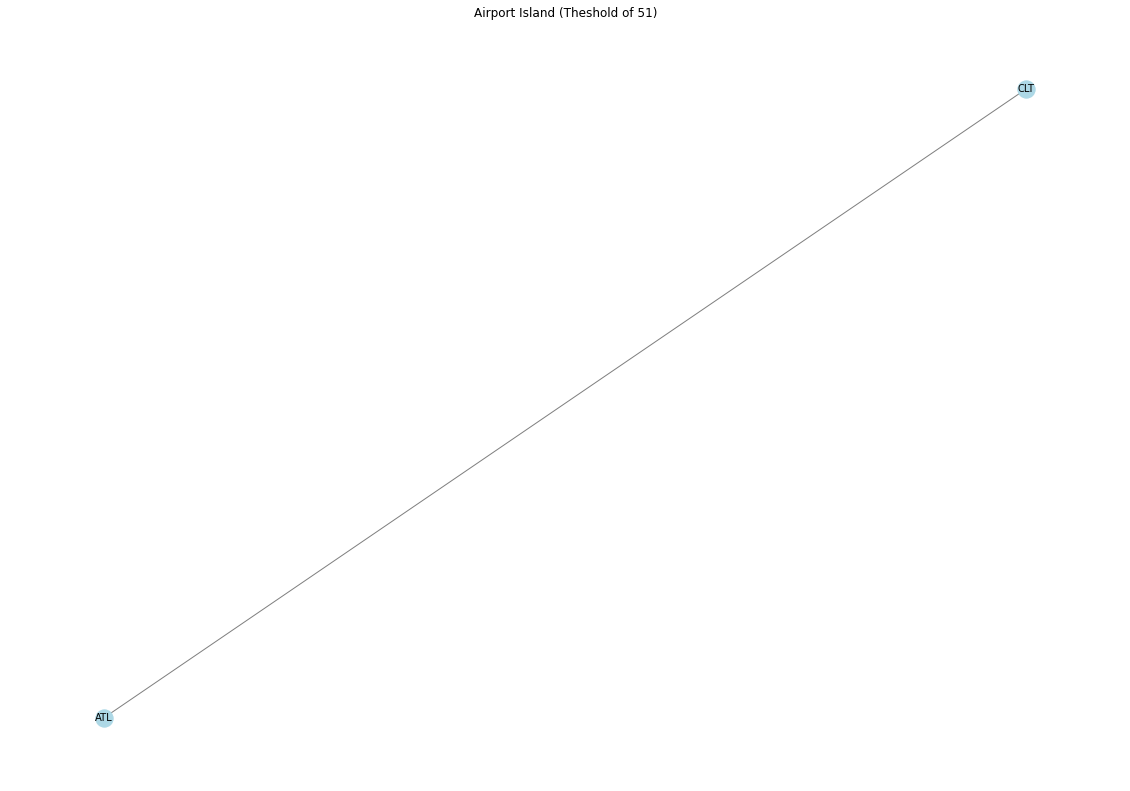

In [23]:
plt.figure(figsize=(20,14))

nx.draw_networkx(airport_islands[5][1], pos, node_size=300, font_size=10, node_color='lightblue', edge_color='grey')

plt.title("Airport Island (Theshold of 51)")
plt.axis("off")
plt.show()

The airports included in the network when filtered to a threshold of 51 are ATL (Atlanta) and CLT (North Carolina). These were both amongst the top 10 airports. Both of these are also considered major hubs. In fact, ATL is one of the busiest airports in the world ([source](https://www.ajc.com/news/atlanta-airport-blog/hartsfield-jackson-retains-title-for-worlds-busiest-airport/Z7DGTDDJURC3LPWWLD3M2T65IE/#:~:text=Busiest%20airports%20in%20the%20world,people%20passing%20through%20local%20terminals.)).

*** 

### Destinations

In [24]:
destinations = bipartite.weighted_projected_graph(G, survey['DEST_STATE_ABR'])

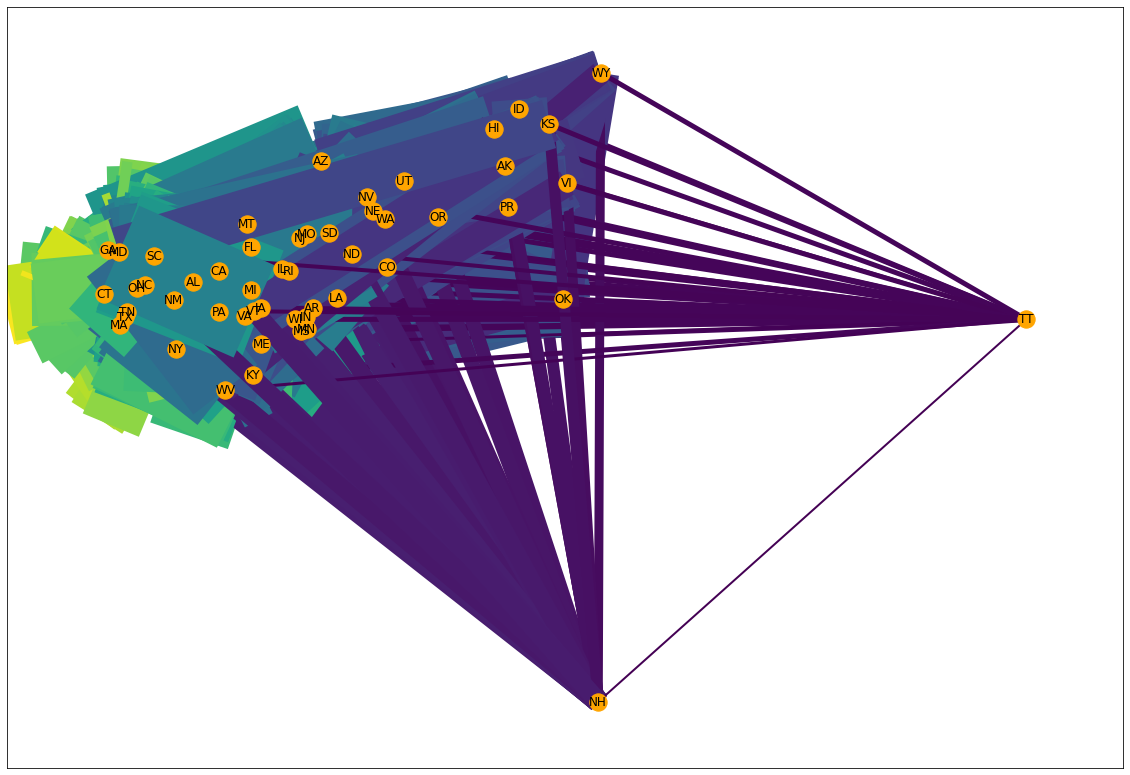

In [25]:
plt.figure(figsize=(20,14))

weights = [edata['weight'] for f, t, edata in destinations.edges(data = True)]
nx.draw_networkx(destinations, pos, width = weights, edge_color = weights, node_color = 'orange')

plt.show()

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([51.5, 51.6, 51.7, 51.8, 51.9, 52. , 52.1, 52.2, 52.3, 52.4, 52.5]),
 <BarContainer object of 10 artists>)

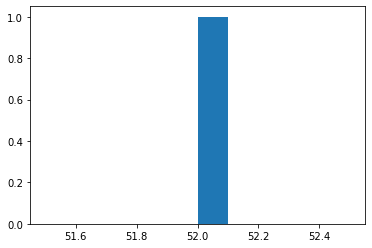

In [26]:
x=[len(c) for c in nx.connected_components(destinations)]
plt.hist(x)

In [27]:
dest_islands = island_method(destinations)

for i in dest_islands:
    print(i[0], nx.number_of_nodes(i[1]), nx.number_connected_components(i[1]))

2 52 1
47 49 1
92 40 1
137 25 1
182 10 1
227 3 1


With a threshold of 137 there is one connected component of 25 nodes. With a threshold of 182 there is one connected component of 10 nodes. 

In [28]:
# find the top 10
top_10_dest = survey.groupby('DEST_STATE_ABR').count().iloc[:,0].sort_values(ascending=False).head(10).to_dict()

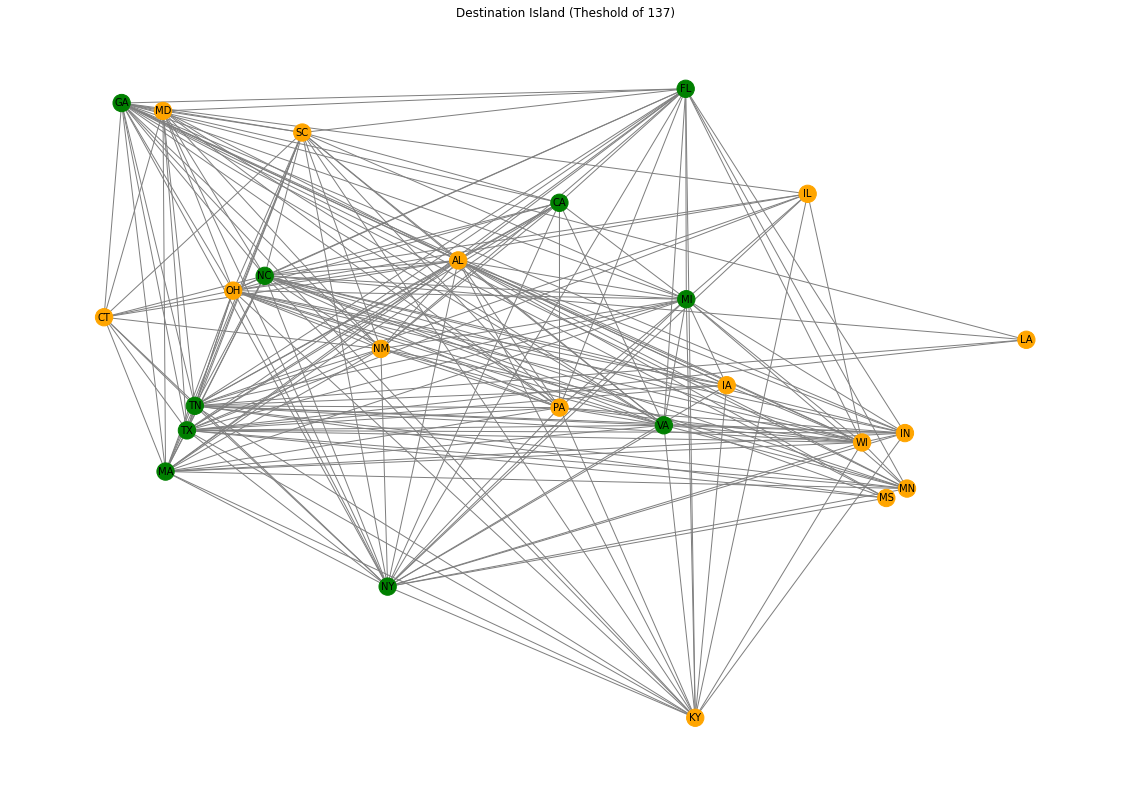

In [29]:
plt.figure(figsize=(20,14))

# create color dictionary
color_dict = {}

for node in dest_islands[3][1].nodes():
    if node in top_10_dest.keys():
        color_dict[node] = 'green'   # green for top 10
    else:
        color_dict[node] = 'orange'  # orange for others

nx.draw_networkx(dest_islands[3][1], pos, node_size=300, font_size=10, node_color=color_dict.values(), edge_color='grey')

plt.title("Destination Island (Theshold of 137)")
plt.axis("off")
plt.show()

When we graph the network with the threshold of 137, all of the top 10 destinations appear. 

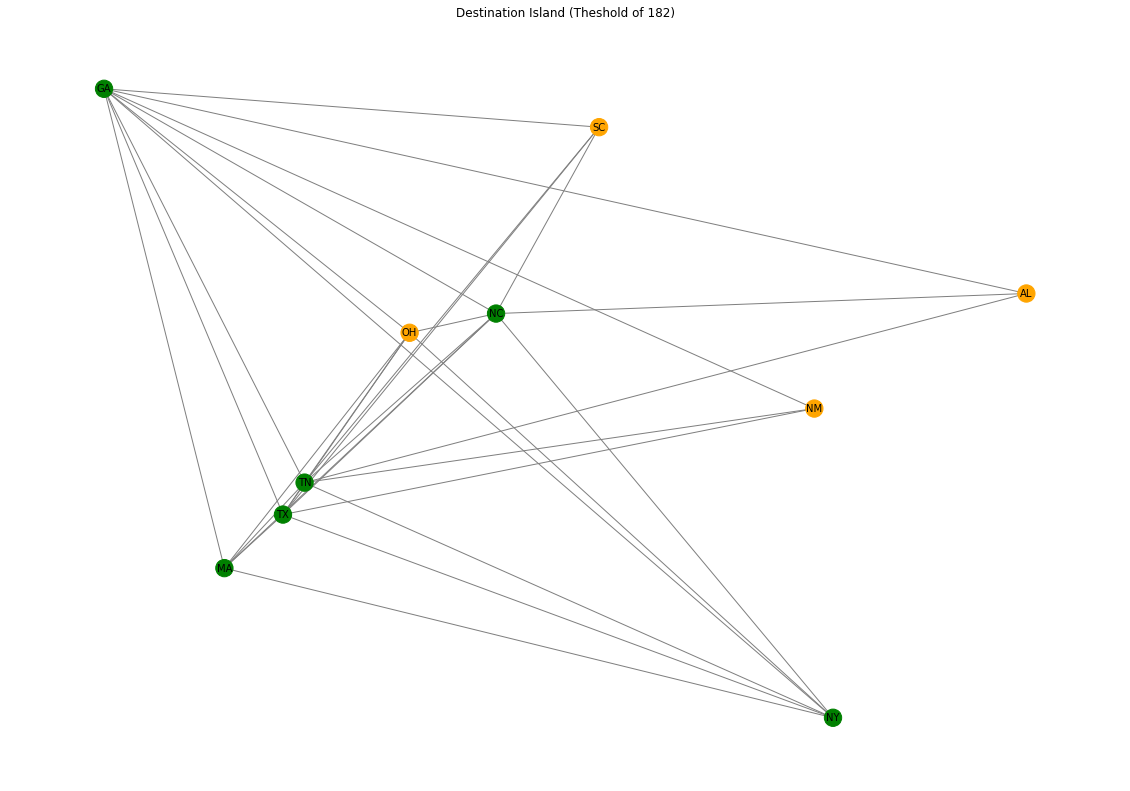

In [30]:
plt.figure(figsize=(20,14))

# create color dictionary
color_dict = {}

for node in dest_islands[4][1].nodes():
    if node in top_10_dest.keys():
        color_dict[node] = 'green'   # green for top 10
    else:
        color_dict[node] = 'orange'  # orange for others

nx.draw_networkx(dest_islands[4][1], pos, node_size=300, font_size=10, node_color=color_dict.values(), edge_color='grey')

plt.title("Destination Island (Theshold of 182)")
plt.axis("off")
plt.show()

When we graph the network with a threshold of 187, only 6 of the top 10 appear. Missing are Florida, California, Virginia, and Michigan. 

***

### Centrality

In [31]:
# function to calculate centralities
def centrality(graph):
    # calculate each of the values for each node
    degree = nx.degree(graph)
    degree_weighted = nx.degree(graph, weight = 'weight')
    degree_c = nx.degree_centrality(graph)
    between_c = nx.betweenness_centrality(graph)
    closeness_c = nx.closeness_centrality(graph)
    #eigen_c = nx.eigenvector_centrality(graph, weight = 'weight') 

    # create a list for each node with all the data points
    data = [[name
             , degree[name]
             , degree_weighted[name]
             , round(degree_c[name], 3)
             , round(between_c[name], 3)
             , round(closeness_c[name], 3)] 
             for name in graph.nodes()]
    
    # turn this into a dataframe
    centrality_df = pd.DataFrame(data
                                 , columns = ['name', 'degree', 'weighted_degree', 'degree centrality'
                                              , 'betweenness', 'closeness'])
    
    # return the dataframe
    return centrality_df

Let's calculate centralities for the airports.

In [32]:
centrality(airports).sort_values(by = ['weighted_degree'], ascending = False)

,name,degree,weighted_degree,degree centrality,betweenness,closeness
16,ATL,296,7081,1.000,0.0,1.000
115,CLT,296,7081,1.000,0.0,1.000
27,AUS,296,7077,1.000,0.0,1.000
31,BNA,296,7077,1.000,0.0,1.000
5,EYW,296,6995,1.000,0.0,1.000
...,...,...,...,...,...,...
208,HIB,163,163,0.551,0.0,0.690
211,IMT,156,156,0.527,0.0,0.679
213,RDD,146,146,0.493,0.0,0.664
191,HOM,109,109,0.368,0.0,0.613


In the top 5 airports with the highested weighted centrality we see ATL, CLT, AUS, BNA, and EYW. While ATL and CLT are confisered major hubs, AUS, BNA, and EYW (Key West Airport in Florida) are not considered major hubs. The reason they appear here could be because they are connected to other airports that do serve as major hubs or they may simply have many flights to popular destinations which people also fly to from major hubs. 

Now let's calculate centralities for the destinations. 

In [33]:
centrality(destinations).sort_values(by = ['weighted_degree'], ascending = False)

,name,degree,weighted_degree,degree centrality,betweenness,closeness
4,GA,51,6745,1.0,0.0,1.0
36,TN,51,6682,1.0,0.0,1.0
13,TX,51,6653,1.0,0.0,1.0
8,NC,51,6410,1.0,0.0,1.0
3,NY,51,6323,1.0,0.0,1.0
6,MA,51,6202,1.0,0.0,1.0
7,OH,51,6142,1.0,0.0,1.0
23,AL,51,5988,1.0,0.0,1.0
0,FL,51,5890,1.0,0.0,1.0
41,NM,51,5875,1.0,0.0,1.0


The degree centrality for all of the destinations is the same, so they are all connected. However, the weighted degree is highest for Georgia, Tennessee, Texas, North Carolina, and New York. This would seem to indicate that these are very popular destinations, as there are many flights from many airports to these locations. 